# Initialize


In [1]:
%load_ext autoreload
%autoreload 2


In [ ]:
import torch
from torchvision import datasets, transforms
import numpy as np
#import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


from model import VAE_priorCategorical, VAE_priorHFM
import metadata as md
from datasets import Dataset_HFM, Dataset_pureHFM, load_dsprites
# from utilities import  get_empirical_latent_distribution, sample_images
from find_gauge import return_minimum_kl_in_g_range
from find_gauge import plot_kl_multiline_from_dicts, save_individual_plots_from_dicts, create_combined_multiline_plot




In [3]:
device = torch.device('cpu')


# Datasets


## dSprites


In [ ]:
train_loader_dSprites, val_loader_dSprites = load_dsprites()


## MNIST


In [4]:
train_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=True
    )

val_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=False
    )


## FashionMNIST


In [ ]:
train_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=True
    )

val_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=False
    )
## pureHFM
dataset_HFM_train = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_pureHFM = DataLoader(
    dataset_HFM_train,
    batch_size=md.batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_pureHFM = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size=md.batch_size,
    shuffle=False
)
## expandedHFM 32-1024
dataset_HFM_train = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_train,
    batch_size=md.batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size=md.batch_size,
    shuffle=False
)
# PriorHFM, klG = log2

# PriorHFM

## train over MNIST


**OSS:** The analysis was executed to some mixed lambda trained VAE too (lamda = 1 for layers 1,2,3,4; lambda = 0.1 for layers 5,6), and the results are approxiamtely the same.

In [20]:
train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 784


### Previous calculations

In [ ]:
# for g in np.arange(0.1, 2, 0.2):
#     print("____________________________________________")
#     print(f"Processing g = {g}")

#     var_name = f"kl_divergences_lmb01_{str(round(g, 2)).replace('.', '')}"
#     globals()[var_name] = []

#     # hidden layer = 1
#     my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
#     my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
#     globals()[var_name].append(return_minimum_kl(my_model, train_loader, device, g))

#     # hidden layer = 2
#     my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
#     my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
#     globals()[var_name].append(return_minimum_kl(my_model, train_loader, device, g))

#     # hidden layer = 3
#     my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
#     my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
#     globals()[var_name].append(return_minimum_kl(my_model, train_loader, device, g))

#     # hidden layer = 4
#     my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
#     my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
#     globals()[var_name].append(return_minimum_kl(my_model, train_loader, device, g))

#     # hidden layer = 5
#     my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
#     my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
#     globals()[var_name].append(return_minimum_kl(my_model, train_loader, device, g))

#     # hidden layer = 6
#     my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
#     my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
#     globals()[var_name].append(return_minimum_kl(my_model, train_loader, device, g))



# data_to_save = {}
# for g in np.arange(0.1, 2, 0.2):
#     var_name = f"kl_divergences_lmb01_{str(round(g, 2)).replace('.', '')}"
#     if var_name in globals():
#         data_to_save[var_name] = np.array(globals()[var_name])


# np.savez('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/kl_divergences_priorCategorical_MNIST_lmb01.npz', **data_to_save)

# plot_kl_multiline(np.arange(0.1, 2, 0.2), var_name_prefix="kl_divergences_lmb01", title="Lambda = 0.1")

# save_individual_plots("/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/kl_divergence_priorCategorical_MNIST/lmb01", np.arange(0.1, 2, 0.2))


____________________________________________
Processing g = 0.1
Feature frequencies: [0.49583333 0.54381667 0.46478333 0.45595    0.44476667 0.52273333
 0.47725    0.4425    ], Sorted indices: [1 5 0 6 2 3 4 7]
Processed 10000 permutations, current minimum KL: 0.33234596252441406, best permutation: (1, 3, 6, 2, 0, 5, 4, 7)
Processed 20000 permutations, current minimum KL: 0.33234596252441406, best permutation: (1, 3, 6, 2, 0, 5, 4, 7)
Processed 30000 permutations, current minimum KL: 0.33234596252441406, best permutation: (1, 3, 6, 2, 0, 5, 4, 7)
Processed 40000 permutations, current minimum KL: 0.33234596252441406, best permutation: (1, 3, 6, 2, 0, 5, 4, 7)
Minimum KL divergence: 0.33234596252441406
Feature frequencies: [0.46023333 0.55815    0.4373     0.46316667 0.51475    0.5356
 0.46705    0.5171    ], Sorted indices: [1 5 7 4 6 3 0 2]
Processed 10000 permutations, current minimum KL: 0.29062747955322266, best permutation: (0, 3, 1, 2, 5, 4, 6, 7)
Processed 20000 permutations, cur

### latent_dim = 8


In [22]:
g_values=np.arange(0.1, 2, 0.2)
layer_dicts = []

# hidden layer = 1
my_model = VAE_priorCategorical(input_dim=input_dim, categorical_dim=2, latent_dim=8, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 1 hidden layer...")
layer_dicts.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 2 hidden layers...")
layer_dicts.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 3 hidden layers...")
layer_dicts.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 4 hidden layers...")
layer_dicts.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 5 hidden layers...")
layer_dicts.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("---------------\n")

my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=8, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
print("Calculating KL divergences for model with 6 hidden layers...")
layer_dicts.append(return_minimum_kl_in_g_range(my_model, train_loader, device, g_values))
print("--------------------------\n")



Calculating KL divergences for model with 1 hidden layer...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Evaluating the best gauge of the latent states...
Total permutations processed: 40320, Minimum KL: 0.3329887390136719, Best permutation: (5, 6, 4, 0, 1, 7, 2, 3)
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Total permutations processed: 40320, Minimum KL: 0.3329887390136719, Best permutation: (5, 6, 4, 0, 1, 7, 2, 3)
Calculating the KL divergence for different g values...
---------------

Calculating KL divergences for model with 2 hidden layers...
Obtaining the internal latent distribution of the model...
Evaluating the best gauge of the latent states...
Evaluating the best gauge of the latent states...
Total permutations processed: 40320, Minimum KL: 0.2889580726623535, Be

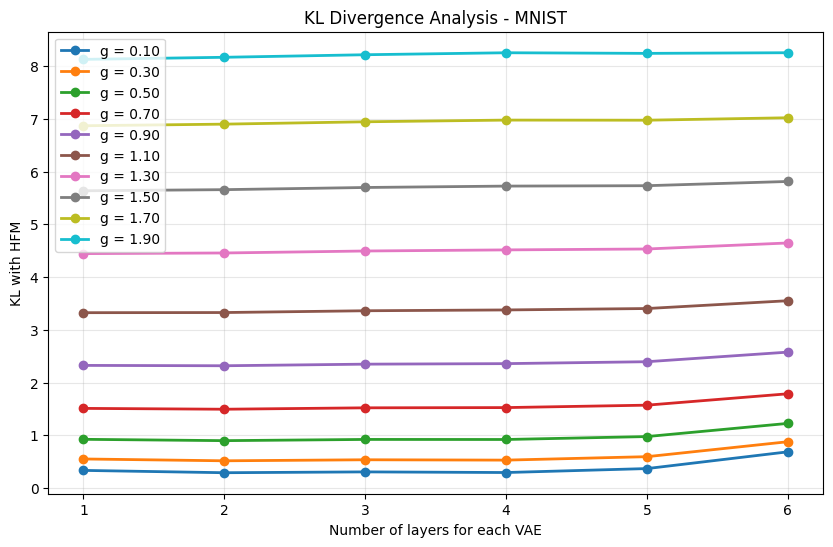

In [24]:
# Example usage of the new plotting functions
# Assuming you have the dictionaries from the first cell:
# kl_divergences_1_layers, kl_divergences_2_layers, ..., kl_divergences_6_layers

# Create a list of your layer dictionaries

g_values = np.arange(0.1, 2, 0.2)

# Create multi-line plot
plot_kl_multiline_from_dicts(layer_dicts, g_values, title="KL Divergence Analysis - MNIST")

# Save individual plots
save_individual_plots_from_dicts(
    layer_dicts, 
    g_values, 
    "/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini//Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/kl_divergence_priorCategorical_MNIST/",
    title_prefix="MNIST Analysis"
)

# Create and save combined plot
create_combined_multiline_plot(
    layer_dicts, 
    g_values,
    save_path="/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini//Users/enricofrausin/Programmazione/PythonProjects/Fisica/Immagini/kl_divergence_priorCategorical_MNIST/kl_divergences_combined_depth_analysis.png",
    title="KL Divergence vs Number of Layers - MNIST Dataset"
)